# Autonomous Driving and ADAS Technologies 
#### Trajectory Reconstrucion 


In [36]:
# Import all the necessary libraries

from math import sin, cos, atan2, sqrt
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from matplotlib.patches import Circle
from scipy.spatial.transform import Rotation as R
from filterpy.kalman import KalmanFilter
from scipy.interpolate import splprep, splev
from scipy.interpolate import BSpline
from scipy import interpolate

In [37]:
# Data Opener 

vo_file_path = '/Users/carpanini24/Downloads/vo_new-1.dat'
objects_file_path = '/Users/carpanini24/Downloads/setOfCoord-1.dat'
cov_mat_file_path = '/Users/carpanini24/Downloads/cov_new-1.dat'
numberFrame_cone = 1020 # Change this number according to the frame number you want to see (1020 a complete LAP)

In [38]:
# Roto-Translation Functions
# In order to perform roto-translation, we need to define the rotation matrix and the translation vector
# The matrix is a 4x4 matrix with the following structure:
# [rotation_matrix, translation_vector]
# [0, 0, 0, 1]

# [R|T]
# [0|1]

def roto_translation(x, y, z, roll, pitch, yaw):
    """
    Function to create a roto-translation matrix
    :param x: x translation
    :param y: y translation
    :param z: z translation
    :param roll: roll angle
    :param pitch: pitch angle
    :param yaw: yaw angle
    :return: 4x4 roto-translation matrix
    """
    # Creation of a rotation matrix around the X axis (roll)
    roll_matrix = np.array([[1, 0, 0],
                           [0, np.cos(roll), -np.sin(roll)],
                           [0, np.sin(roll), np.cos(roll)]])

    # Creation of a rotation matrix around the Y axis (pitch)
    pitch_matrix = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                            [0, 1, 0],
                            [-np.sin(pitch), 0, np.cos(pitch)]])

    # Creation of a rotation matrix around the Z axis (yaw)
    yaw_matrix = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                          [np.sin(yaw), np.cos(yaw), 0],
                          [0, 0, 1]])

    # Rotation matrix: product of the three matrices above (roll, pitch, yaw)
    rotation_matrix = np.dot(np.dot(roll_matrix, pitch_matrix), yaw_matrix)

    # Translation vector: vector of the translation values
    translation_vector = np.array([x, y, z])

    # Combination of rotation and translation matrices into the transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation_vector

    return transformation_matrix

In [39]:
# Camera-World Transformation Functions and Datas 

#Camera Extrinsic Parameters:
baseline = 0.1502038836479187 
yaw = 0.0013
pitch = 0.26064164284305252
roll = 0.001868
x = 0.00000000
y = 0.00000000
z = 1.07381126

# Construct the transformation matrix from camera to world
T_world_to_camera = roto_translation(x, y, z, roll, pitch, yaw)

In [40]:
# Data Opener 

#VO Data -> VO = [x, y, z, roll, pitch, yaw]
with open(vo_file_path, 'r') as file:
    lines = file.readlines()
    time = []
    yaw = []
    pitch = []
    roll = []
    x = []
    y = []
    z = []

    for line in lines:
        if line.strip():
            values = [float(val) for val in line.strip().split()]
            time.append(values[0])
            yaw.append(values[1])
            pitch.append(values[2])
            roll.append(values[3])
            x.append(values[4])
            y.append(values[5])
            z.append(values[6])     
VO = [x, y, z, roll, pitch, yaw]

# CONES Data -> objects_data = [current_frame_data[] ] -> current_frame_data = [(class, x, y, disp)[] ]
with open(objects_file_path, 'r') as file:
    lines = file.readlines()
    objects_data = []
    current_frame_data = []

    for line in lines:
        # If the line is empty, it indicates the end of a frame
        if not line.strip():
            if current_frame_data:
                objects_data.append(np.array(current_frame_data))
                current_frame_data = []
        else:
            # Process the values and add them to the current frame
            values = [float(val) for val in line.strip().split()]
            current_frame_data.append(values)

    # Add the last frame if it's not empty
    if current_frame_data:
        objects_data.append(np.array(current_frame_data))

# COVARINCE MATRICES Data -> covariance_matrices = [cov_matrix[]]
with open(cov_mat_file_path, 'r') as file:
    covariance_matrices = []
    lines = file.readlines()

    for line in lines:
        if line.strip():
            values = [float(val) for val in line.strip().split()]
            values_new = []
            for val in values:
                val = val**2
                values_new.append(val)

            cov_matrix = np.array(values).reshape((6, 6))
            covariance_matrices.append(cov_matrix)

In [41]:
# MatPlotLib Functions - utilis 
# The functions takes as input up to 4 different lists that will be plotted on the same graph
# The function also takes as input up to 4 different strings that will be used as labels for the plots
# The function is useful to plot the VO data, specially for debugging purposes

def plot(list1=None, str1="", list2=None, str2="", list3=None, str3="", list4=None, str4=""):
    """
    Function to plot up to 4 different lists on the same graph
    :param list1: list of values to plot
    :param str1: label for the first list
    :param list2: list of values to plot
    :param str2: label for the second list
    :param list3: list of values to plot
    :param str3: label for the third list
    :param list4: list of values to plot
    :param str4: label for the fourth list
    :return: None
    """
    
    # If a string is not provided, treat it as an empty string
    str1 = str1 if str1 is not None else ""
    str2 = str2 if str2 is not None else ""
    str3 = str3 if str3 is not None else ""
    str4 = str4 if str4 is not None else ""

    # If a list is not provided, treat it as an empty list
    if list1 is not None:
        list1 = np.array(list1)
        plt.plot(list1[:,0], list1[:,1], label=str1, c = 'orange')
    if list2 is not None:
        list2 = np.array(list2)
        plt.plot(list2[:,0], list2[:,1], label=str2, c = (130/255, 197/255, 35/255))
    if list3 is not None:
        list3 = np.array(list3)
        plt.plot(list3[:,0], list3[:,1], label=str3, c = (0/255, 96/255, 191/255))
    if list4 is not None:
        list4 = np.array(list4)
        plt.plot(list4[:,0], list4[:,1], label=str4, c = 'red')

    plt.legend()
    plt.xlabel('X position [m]')
    plt.ylabel('Y position [m]')
    plt.title('Trajectory Reconstruction')
    plt.axis('equal')
    plt.show()


In [42]:
# Reconstruction function  of the trajectory of the car by using the VO data
# position = [x, y, z, roll, pitch, yaw] -> CRF
# position_complete = [x_c, y_c, z_c, roll_c, pitch_c, yaw_c] -> WRF
    
def reconstruct_trajectory(VO:list, numberFrame_cone:int, k:int):
    """
    reconstruct_trajectory reconstructs the trajectory of the car by using the VO data
    :param VO: list of VO data
    :param numberFrame_cone: number of frames
    :param k: k = 1 (kalman filter ON), K = 0 (kalman filter OFF)
    :return: list of the reconstructed trajectory both in CRF and WRF
    """

    m_Twb = np.identity(4)
    # Initialization of a list for navigation results
    position = []
    position_complete = []

    for i in range(numberFrame_cone):
        # Matrices initialization
        # Tpc -> transformation, prev to curr (previous frame to current frame)
        Tpc = np.eye(6)

        # Extract the values from the list VO
        if (k == 0):
            translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle = VO[0][i], VO[1][i], VO[2][i], VO[3][i], VO[4][i], VO[5][i]
        if (k == 1):
            translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle = VO[i][0], VO[i][1], VO[i][2], VO[i][3], VO[i][4], VO[i][5]
        
        Tpc = roto_translation(translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle)

        # Compute the curr-to-prev matrix from Tpc
        # It is needed if we want to compute the speed as well
        Tcp_mat = np.linalg.inv(Tpc)

        # Product of the transformation matrix with the world-to-body matrix
        m_Twb = np.dot(Tpc, m_Twb)

        # Compute the inverse matrix of the world-to-body matrix -> the result is the body-to-world matrix
        Twb_mat = np.linalg.inv(m_Twb)

        Twb_mat_world = np.dot(T_world_to_camera, Twb_mat)

        # Extract the values from the matrix
        x = Twb_mat[0, 3]
        y = Twb_mat[1, 3]
        z = Twb_mat[2, 3]

        x_c = Twb_mat_world[0, 3]
        y_c = Twb_mat_world[1, 3]
        z_c = Twb_mat_world[2, 3]

        yaw = np.arctan2(Twb_mat[1, 0], Twb_mat[0, 0])
        pitch = np.arctan2(-Twb_mat[2, 0], np.sqrt(Twb_mat[2, 1]**2 + Twb_mat[2, 2]**2))
        roll = np.arctan2(Twb_mat[2, 1], Twb_mat[2, 2])

        yaw_c = np.arctan2(Twb_mat_world[1, 0], Twb_mat_world[0, 0])
        pitch_c = np.arctan2(-Twb_mat_world[2, 0], np.sqrt(Twb_mat_world[2, 1]**2 + Twb_mat_world[2, 2]**2))
        roll_c = np.arctan2(Twb_mat_world[2, 1], Twb_mat_world[2, 2])

        # Append the values to the list position
        position.append([x, y, z, roll, pitch, yaw])
        position_complete.append([x_c, y_c, z_c, roll_c, pitch_c, yaw_c])

    return position, position_complete

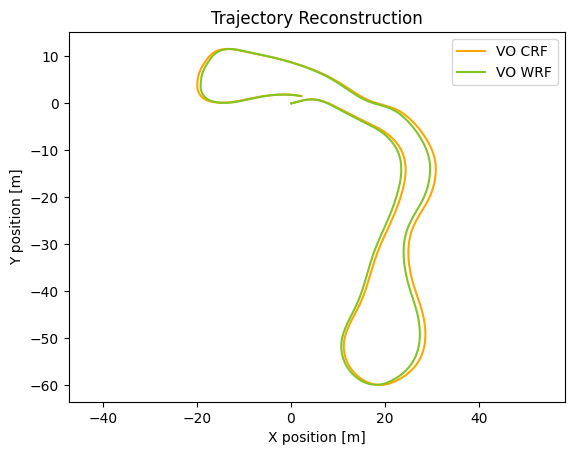

In [43]:
# Reconstruction of the trajectory of the car by using the VO data (Right Camera)

position, position_complete = reconstruct_trajectory(VO, numberFrame_cone, 0)
# Plot the trajectory of the car
plot(position, "VO CRF", position_complete, "VO WRF")

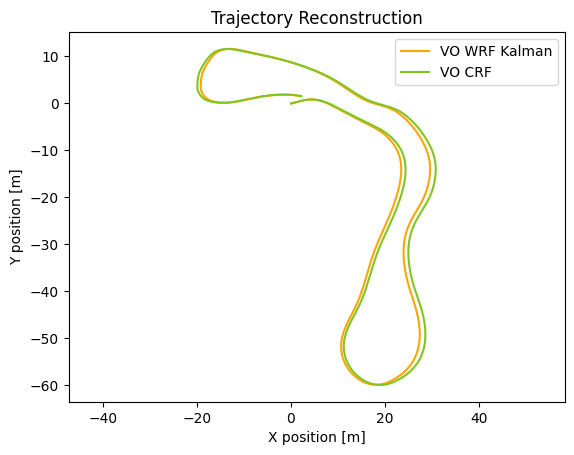

In [44]:
# Reconstruction of the trajectory of the car by using the VO data and apply a Kalman Filter
# Kalman Filter -> implemented by using the library pykalman
# The Kalman Filter is used to estimate the state of a linear dynamic system from a series of noisy measurements

# Define Kalman filter
kf = KalmanFilter(dim_x=6, dim_z=6)

# Set initial values for Kalman filter parameters
kf.H = np.eye(6)   # Measurement matrix
kf.F = np.eye(6)  # State transition matrix

# Values that can be changed to improve the performance of the Kalman filter
value1 = 7e-7
value2= 1e-5

# Initialize process noise covariance matrix
kf.Q *= value1

# Initialize the state and covariance
kf.x = position[0]
kf.P *= value2

VO_kalman = []

for i in range(len(position)):
    translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle = VO[0][i], VO[1][i], VO[2][i], VO[3][i], VO[4][i], VO[5][i]
    rototranslation = np.array([translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle])  # 3D rototranslation 
    covariance_matrix = covariance_matrices[i]  # 6x6 covariance matrix
    kf.R = covariance_matrix
    measurement = np.array(rototranslation)

    # Kalman filter prediction and update
    kf.predict()
    kf.update(measurement)

    # Extract updated rototranslation estimate
    updated_rototranslation = kf.x
    VO_kalman.append(updated_rototranslation)
    
# Reconstruction of the trajectory of the car by using the VO data and apply a Kalman Filter
position_kalman, position_kalman_complete = reconstruct_trajectory(VO_kalman, numberFrame_cone, 1)
plot(position_kalman_complete, "VO WRF Kalman", position, "VO CRF")

In [45]:
# Function to find the center of the baseline and calculate the position of the center of the car

def calculate_center_position(right_position, halfBaseline, yaw_angle):
  """
  Calcola la posizione del centro dell'auto.

  Args:
    wheel_position: Tuple con le coordinate 3D (x, y, z) della ruota destra.
    wheel_base: Interasse dell'auto.
    yaw_angle: Angolo di yaw dell'auto.

  Returns:
    Tuple con le coordinate 3D (x, y, z) del centro dell'auto.
  """
  x_center = right_position[0] - halfBaseline * np.sin(yaw_angle)
  y_center = right_position[1] + halfBaseline * np.cos(yaw_angle)
  z_center = right_position[2]
  return x_center, y_center, z_center

In [46]:
# Reconstruction of the trajectory of the center of the baseline (instead of the right camera)

position_center = []
position_center_complete = []
for i in range(numberFrame_cone):
    x_right, y_right, z_right, roll_right, pitch_right, yaw_right = position[i]
    positionR = [x_right, y_right, z_right]
    positionC = calculate_center_position(positionR, 0.30, yaw_right)
    positionCentre = [positionC[0], positionC[1], positionC[2], roll_right, pitch_right, yaw_right]
    position_center.append(positionCentre)

for i in range(numberFrame_cone):
    x_right, y_right, z_right, roll_right, pitch_right, yaw_right = position_complete[i]
    positionR = [x_right, y_right, z_right]
    positionC = calculate_center_position(positionR, 0.30, yaw_right)
    positionCentre = [positionC[0], positionC[1], positionC[2], roll_right, pitch_right, yaw_right]
    position_center_complete.append(positionCentre)


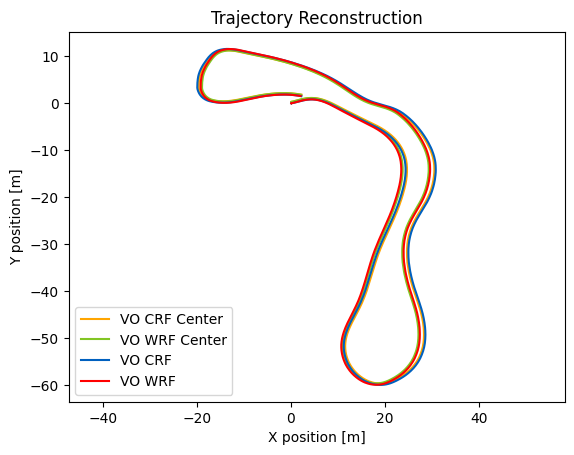

In [47]:
plot(position_center, "VO CRF Center", position_center_complete, "VO WRF Center", position, "VO CRF", position_complete, "VO WRF")

#### Cones Percpetion, Mapping, Tracking

In [48]:
# Function to plot the cones' position in the world frame, the color of the cones is based on their class
# Class 0 -> yellow cone 
# Class 1 -> blue cone
# Class 2 -> orange cone
# Class 3 -> red cone (higher orange cone)

def plotCones(cones_coord_world:list, position:list, title:str):
    """
    Plot the cones' position in the world frame
    Args:
    cones_coord_world: list of cones' coordinates in the world frame
    position: list of the position of the car in the world frame
    """

    cones_coord_world = np.array(cones_coord_world)
    position = np.array(position)


    classes = cones_coord_world[:, 0]
    x_values = cones_coord_world[:, 1]
    y_values = cones_coord_world[:, 2]


    x_vo_values = position[:, 0]
    y_vo_values = position[:, 1]

    # Classes colors
    class_colors = {0: (248/255, 186/255, 0), 1: (0/255, 96/255, 191/255), 2: (255/255, 147/255, 0/255), 3: 'red'}

    # Plot the cones
    for cls in set(classes):
        indices = np.where(classes == cls)
        plt.scatter(x_values[indices], y_values[indices], color=class_colors[cls], label=f'Class {int(cls)}')
        

    plt.plot(x_vo_values, y_vo_values, label='Visual Odometry', c = (130/255, 197/255, 35/255))
    plt.title(title)
    plt.xlabel('X position [m]')
    plt.ylabel('Y position [m]')
    plt.legend()
    plt.axis('equal')
    plt.show()


In [49]:
# Function to create the cones object data in the world frame

def cones_map(objects_data:list, position:list, numberFrame_cone:int):

    cones_coord_world = []
    for i in range(numberFrame_cone):

        position_of_car = position[i]

        for j in range (len(objects_data[i])):
            class_cone, x_cone, y_cone, disp = objects_data[i][j][0], objects_data[i][j][1], objects_data[i][j][2], objects_data[i][j][3]

            # Definition of the 3d point (x, y, z, 1)
            point_cone_3d = np.array([[x_cone],
                                    [y_cone],
                                    [0],
                                    [1]])
            
            # Extract the values from the list that contains the position of the car
            # The values of the yaw angle are shifted by pi/2 because the car is not oriented in the same way as the world frame

            translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle = position_of_car[0], position_of_car[1], position_of_car[2], position_of_car[3], position_of_car[4], position_of_car[5] - np.pi/2

            transformation_matrix = roto_translation(translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle)

            new_position = np.dot(transformation_matrix, point_cone_3d)

            if not (class_cone == 0 and y_cone == 0 and x_cone == 0 and disp == 0):
                cones_coord_world.append([class_cone, new_position[0,0], new_position[1,0], new_position[2,0], disp])
    
    return cones_coord_world

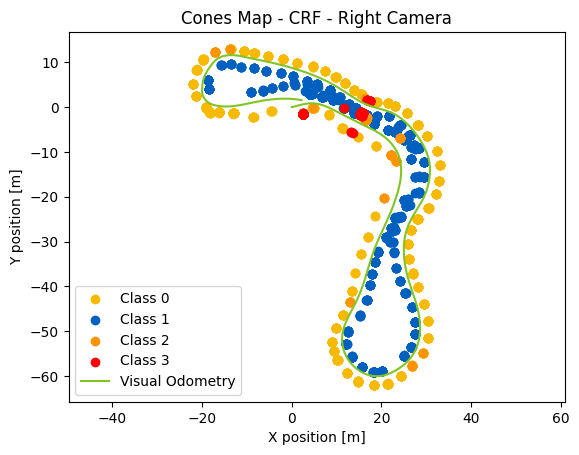

In [50]:
# Reconstruction of the cones' position in the camera reference frame
conesMap = cones_map(objects_data, position, numberFrame_cone)
plotCones(conesMap, position, "Cones Map - CRF - Right Camera")

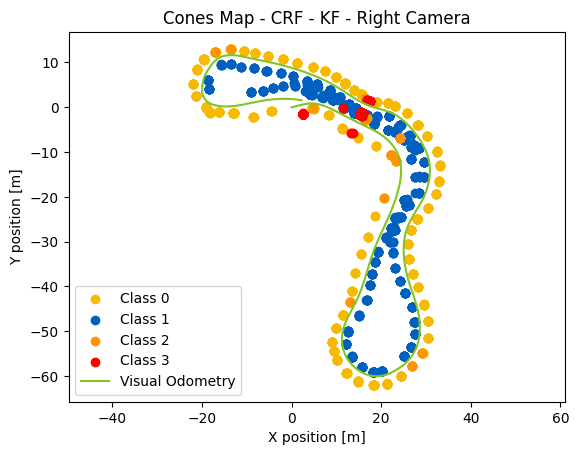

In [51]:
# Reconstruction of the cones' position in the camera reference frame - kalman filter trajectory
conesMap = cones_map(objects_data, position_kalman, numberFrame_cone)
plotCones(conesMap, position_kalman, "Cones Map - CRF - KF - Right Camera")

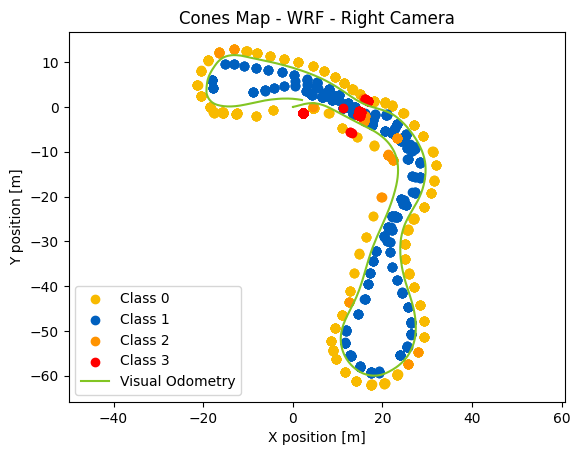

In [52]:
# Reconstruction of the cones' position in the world reference frame
# The cones' position is reconstructed in the world reference frame 

objects_data_world = []
for i in range (len(objects_data)):
    objects_data_world_frame = []
    for j in range (len(objects_data[i])):
        class_cone, x_cone, y_cone, disp = objects_data[i][j][0], objects_data[i][j][1], objects_data[i][j][2], objects_data[i][j][3]
        point_cone_3d = np.array([[x_cone],
                                [y_cone],
                                [0],
                                [1]])
        new_position = np.dot(T_world_to_camera, point_cone_3d)
        if not (class_cone == 0 and y_cone == 0 and x_cone == 0 and disp == 0):
            objects_data_world_frame.append([class_cone, new_position[0,0], new_position[1,0], new_position[2,0], disp])
    objects_data_world.append(objects_data_world_frame)

conesMap = cones_map(objects_data_world, position_complete, numberFrame_cone)
plotCones(conesMap, position_complete, "Cones Map - WRF - Right Camera")

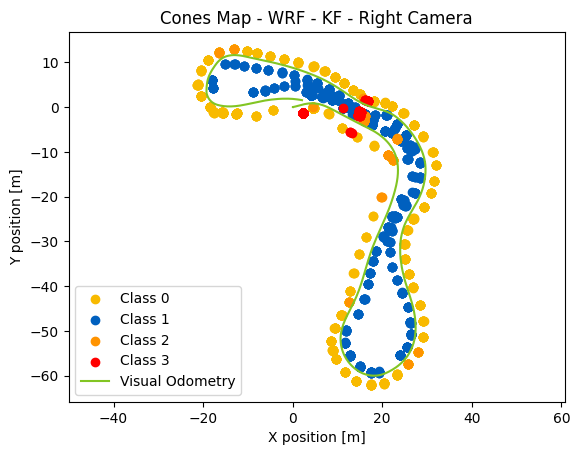

In [53]:
# Reconstruction of the cones' position in the world reference frame - kalman filter trajectory
conesMap = cones_map(objects_data_world, position_kalman_complete, numberFrame_cone)
plotCones(conesMap, position_kalman_complete, "Cones Map - WRF - KF - Right Camera")

In [54]:
# Reconstruction of the cones' position in the world reference frame - center of the baseline

baseline = 0.1502038836479187 
yaw = 0.0013
pitch = 0.26064164284305252
roll = 0.001868
x = -baseline/2
y = 0.000000
z = 1.07381126

# Construct the transformation matrix from camera to world
T_world_right_to_centre = roto_translation(x, y, z, roll, pitch, yaw)

objects_data_world_centre = []
for i in range (len(objects_data)):
    objects_data_world_centre_frame = []
    for j in range (len(objects_data[i])):
        class_cone, x_cone, y_cone, disp = objects_data[i][j][0], objects_data[i][j][1], objects_data[i][j][2], objects_data[i][j][3]
        point_cone_3d = np.array([[x_cone],
                                [y_cone],
                                [0],
                                [1]])
        new_position = np.dot(T_world_right_to_centre, point_cone_3d)
        if not (class_cone == 0 and y_cone == 0 and x_cone == 0 and disp == 0):
            objects_data_world_centre_frame.append([class_cone, new_position[0,0], new_position[1,0], new_position[2,0], disp])
    objects_data_world_centre.append(objects_data_world_centre_frame)

object_data_center = []
for i in range (len(objects_data)):
    objects_data_center_frame = []
    for j in range (len(objects_data[i])):
        class_cone, x_cone, y_cone, disp = objects_data[i][j][0], objects_data[i][j][1], objects_data[i][j][2], objects_data[i][j][3]
        point_cone_3d = np.array([[x_cone],
                                [y_cone],
                                [0],
                                [1]])
        new_position = np.dot(T_world_right_to_centre, point_cone_3d)
        if not (class_cone == 0 and y_cone == 0 and x_cone == 0 and disp == 0):
            objects_data_center_frame.append([class_cone, new_position[0,0], new_position[1,0], new_position[2,0], disp])
    object_data_center.append(objects_data_center_frame)

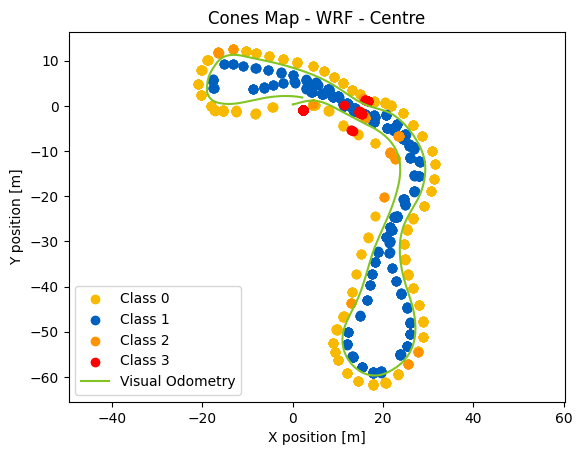

In [55]:
conesMap = cones_map(objects_data_world_centre, position_center_complete, numberFrame_cone)
plotCones(conesMap, position_center_complete, "Cones Map - WRF - Centre")


In [56]:
# Reconstruction of the cones' position in the world reference frame - kalman filter trajectory - center of the baseline
# Use the same Kalman FIlter seen before and just updrate the roto-translation

position_center_kalman = []
position_center_complete_kalman = []
for i in range(numberFrame_cone):
    x_right, y_right, z_right, roll_right, pitch_right, yaw_right = position_center[i]
    positionR = [x_right, y_right, z_right]
    positionC = calculate_center_position(positionR, baseline/2, yaw_right)
    positionCentre = [positionC[0], positionC[1], positionC[2], roll_right, pitch_right, yaw_right]
    position_center_kalman.append(positionCentre)

for i in range(numberFrame_cone):
    x_right, y_right, z_right, roll_right, pitch_right, yaw_right = position_center_complete[i]
    positionR = [x_right, y_right, z_right]
    positionC = calculate_center_position(positionR, baseline/2, yaw_right)
    positionCentre = [positionC[0], positionC[1], positionC[2], roll_right, pitch_right, yaw_right]
    position_center_complete_kalman.append(positionCentre)


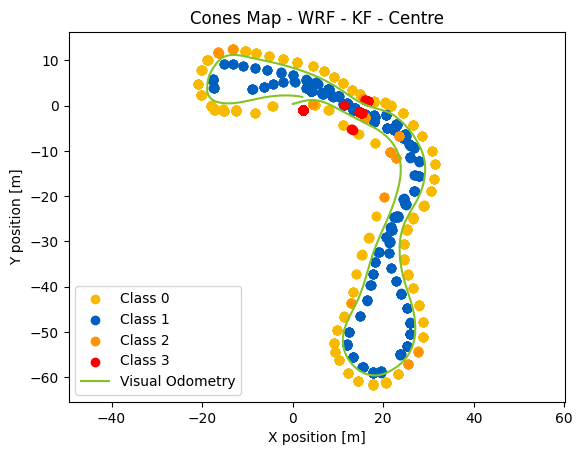

In [57]:
conesMap = cones_map(objects_data_world_centre, position_center_complete_kalman, numberFrame_cone)
plotCones(conesMap, position_center_complete_kalman, "Cones Map - WRF - KF - Centre")

In [58]:
# Cones tracking - function to merge cones

# Merging cones - Track the cones

def merge_cones(cones_coord_world:list, distance_threshold:float):
    """
    Merge cones that are close to each other
    Args:
    cones_coord_world: list of cones' coordinates in the world frame
    distance_threshold: distance threshold for merging cones
    Returns:
    list of merged cones
    """
    cones_coord_world = np.array(cones_coord_world)
    # Extract positions for spatial indexing
    positions = cones_coord_world[:, 1:3]

    # Build a k-d tree for efficient spatial search
    kdtree = cKDTree(positions)

    # Process each cone
    result_cones = []
    for cone in cones_coord_world:
        # Find cones within the distance threshold
        indices = kdtree.query_ball_point(cone[1:3], distance_threshold)
        #print(indices, 'indices')

        # Extract cone data within the threshold
        nearby_cones = cones_coord_world[indices]
        #print(nearby_cones, 'nearby_cones')
        if (len(nearby_cones) > 1):
            totalClass = [0,0,0,0]
            totalClass = np.array(totalClass)
            for cn in nearby_cones:
                if cn[0] == 0:
                    totalClass[0] = totalClass[0] + 1
                if cn[0] == 1:
                    totalClass[1] = totalClass[1] + 1
                if cn[0] == 2:
                    totalClass[2] = totalClass[2] + 1
                if cn[0] == 3:
                    totalClass[3] = totalClass[3] + 1
                cnClass = cn[0]
            
            avgClass = np.argmax(totalClass)
            

            # Sort by disparity and choose the two highest disparity cones
            # sorted_cones = nearby_cones[np.argsort(nearby_cones[:, 3])[::-1]][:2]

            # Take the cone with the highest disparity
            max_disparity_cone = nearby_cones[np.argsort(nearby_cones[:, 3])[::-1]][:1]

            avg_position = max_disparity_cone[:, 1:3][0]
            avg_disparity = max_disparity_cone[:, 3][0]

            # Calculate the average position for the merged cone
            # avg_position = np.mean(sorted_cones[:, 1:3], axis=0)
            # avg_disparity = np.mean(sorted_cones[:, 3])

            # Create the merged cone object
            merged_cone = [avgClass, *avg_position, avg_disparity]

            # Add the cone to the list if only it is not already inside
            if not any(np.allclose(existing_cone, merged_cone) for existing_cone in result_cones):
                result_cones.append(merged_cone)

    
    return result_cones

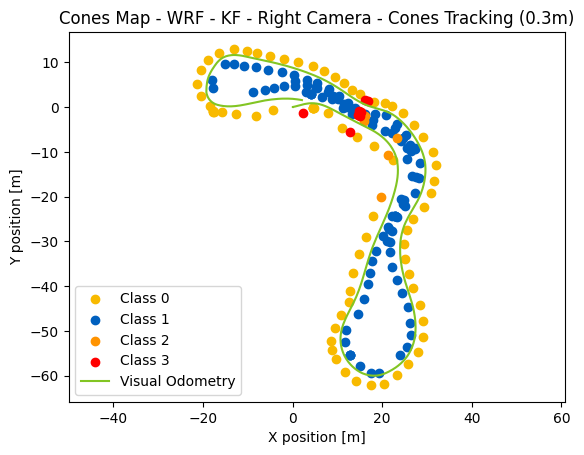

In [59]:
# Cones tracking - visualization of the merged cones  

conesMap = cones_map(objects_data_world, position_kalman_complete, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.3)
plotCones(conesMap, position_kalman_complete, "Cones Map - WRF - KF - Right Camera - Cones Tracking (0.3m)")


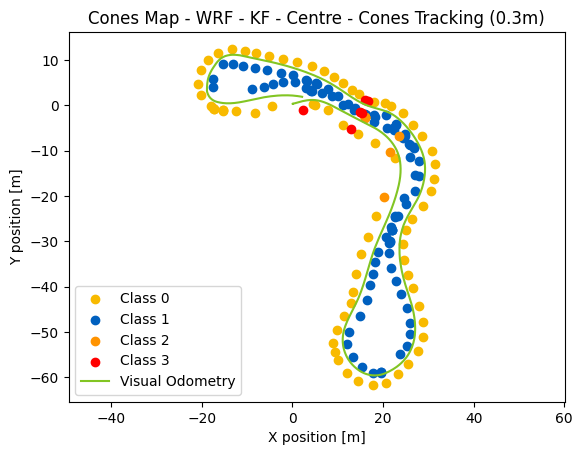

In [60]:
# Cones tracking - visualization of the merged cones - center of the baseline

conesMap = cones_map(objects_data_world_centre, position_center_complete_kalman, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.3)
plotCones(conesMap, position_center_complete_kalman, "Cones Map - WRF - KF - Centre - Cones Tracking (0.3m)")

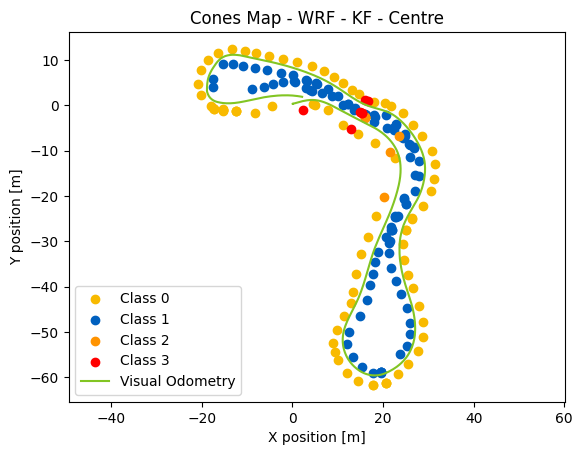

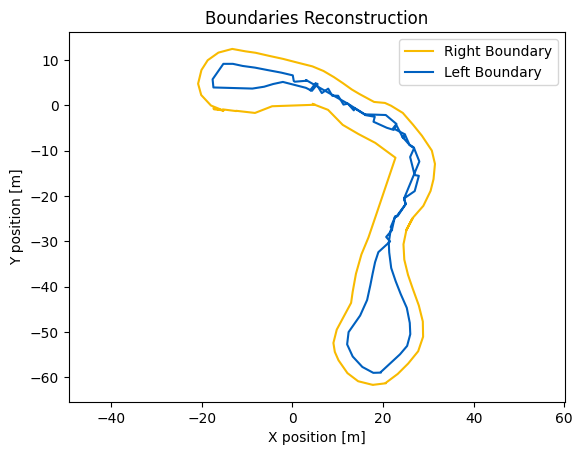

In [62]:
conesMap = cones_map(objects_data_world_centre, position_center_complete_kalman, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.25)
plotCones(conesMap, position_center_complete_kalman, "Cones Map - WRF - KF - Centre")
cones0 = []
cones1 = []
cones2 = []
for cone in conesMap:
    if cone[0] == 0:
        cones0.append(cone)
    if cone[0] == 1:
        cones1.append(cone)
    if cone[0] == 2:
        cones2.append(cone)
cones0 = np.array(cones0)
cones1 = np.array(cones1)
cones2 = np.array(cones2)

plt.plot(cones0[:,1], cones0[:,2], color = (248/255, 186/255, 0), label = 'Right Boundary')
plt.plot(cones1[:,1], cones1[:,2], color = (0/255, 96/255, 191/255), label = 'Left Boundary')
plt.legend()
plt.xlabel('X position [m]')
plt.ylabel('Y position [m]')
plt.title('Boundaries Reconstruction')
plt.axis('equal')
plt.show()

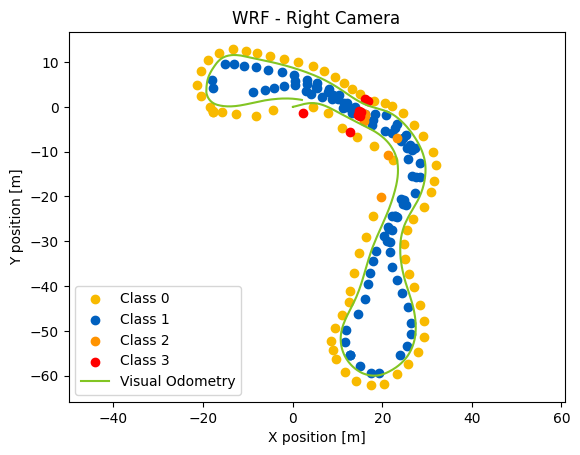

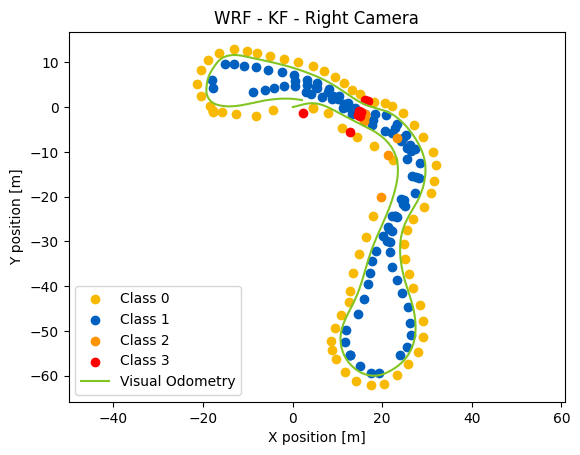

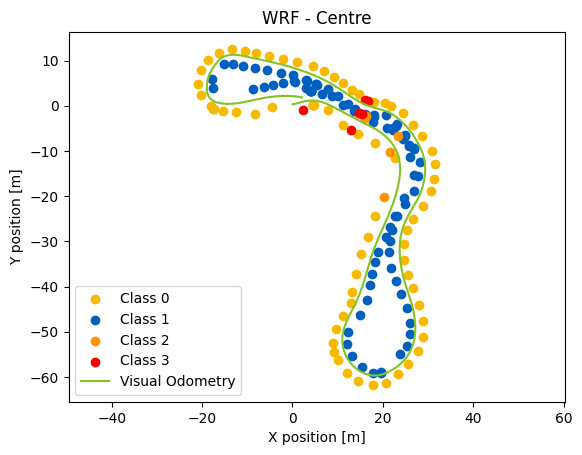

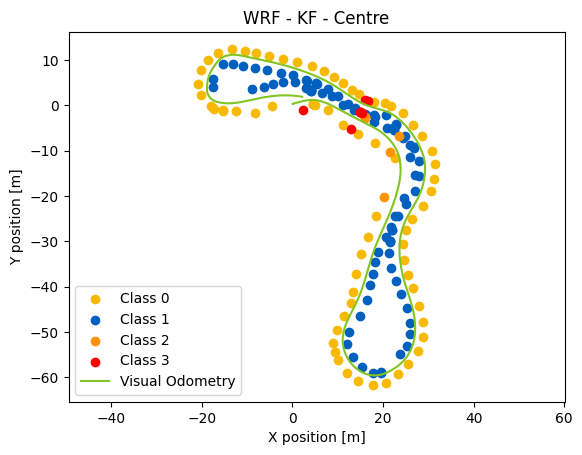

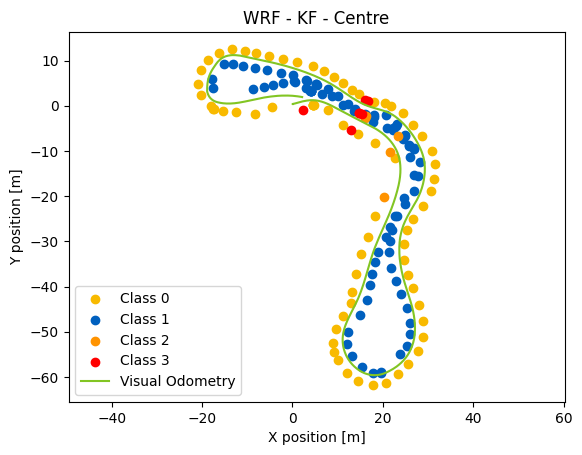

In [63]:
# Plotting some examples of the cones' position in the different reference frames + tracking

conesMap = cones_map(objects_data_world, position_complete, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.35)
plotCones(conesMap, position_complete, "WRF - Right Camera")

conesMap = cones_map(objects_data_world, position_kalman_complete, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.35)
plotCones(conesMap, position_kalman_complete, "WRF - KF - Right Camera")

conesMap = cones_map(objects_data_world_centre, position_center_complete, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.35)
plotCones(conesMap, position_center_complete, "WRF - Centre")

conesMap = cones_map(objects_data_world_centre, position_center_complete_kalman, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.35)
plotCones(conesMap, position_center_complete_kalman, "WRF - KF - Centre")

conesMap = cones_map(objects_data_world_centre, position_center_complete, numberFrame_cone)  
conesMap = merge_cones(conesMap, 0.35)
plotCones(conesMap, position_center_complete_kalman, "WRF - KF - Centre")

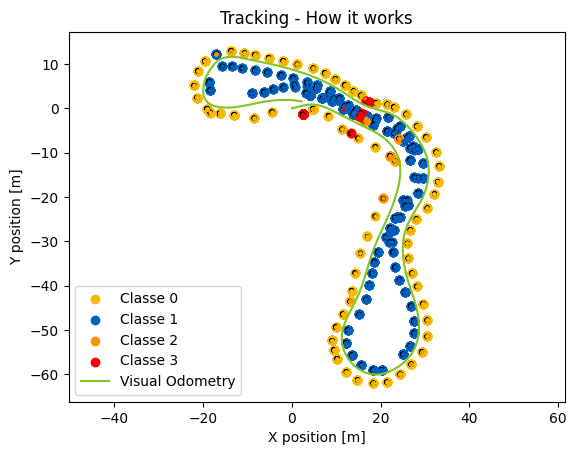

In [69]:
# Plotting the circles in which I am going to search the cones for the tracking

with open(vo_file_path, 'r') as file:
    lines = file.readlines()

    time = []
    yaw = []
    pitch = []
    roll = []
    x = []
    y = []
    z = []

    for line in lines:
        if line.strip():
            values = [float(val) for val in line.strip().split()]
            time.append(values[0])
            yaw.append(values[1])
            pitch.append(values[2])
            roll.append(values[3])
            x.append(values[4])
            y.append(values[5])
            z.append(values[6]) 
    


VO = [x, y, z, roll, pitch, yaw]


m_Twb = np.identity(4)

# Initialization of a list for navigation results
position = []
position_complete = []


for i in range(len(VO[0])):

    # Matrices initialization
    # Tpc -> transformation, prev to curr (previous frame to current frame)
    Tpc = np.eye(4)


    # Extract the values from the list VO
    translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle = VO[0][i], VO[1][i], VO[2][i], VO[3][i], VO[4][i], VO[5][i]

    # Creation of a rotation matrix around the X axis (roll)
    roll = np.array([[1, 0, 0],
                     [0, np.cos(roll_angle), -np.sin(roll_angle)],
                     [0, np.sin(roll_angle), np.cos(roll_angle)]])

    # Creation of a rotation matrix around the Y axis (pitch)
    pitch = np.array([[np.cos(pitch_angle), 0, np.sin(pitch_angle)],
                      [0, 1, 0],
                      [-np.sin(pitch_angle), 0, np.cos(pitch_angle)]])

    # Creation of a rotation matrix around the Z axis (yaw)
    yaw = np.array([[np.cos(yaw_angle), -np.sin(yaw_angle), 0],
                    [np.sin(yaw_angle), np.cos(yaw_angle), 0],
                    [0, 0, 1]])
    

    # Rotation matrix: product of the three matrices above (roll, pitch, yaw)
    rotation_matrix = np.dot(np.dot(roll, pitch), yaw)

    # Translation vector: vector of the translation values
    translation_vector = np.array([translation_x, translation_y, translation_z])

    # Combination of rotation and translation matrices into the transformation matrix
    # The matrix is a 4x4 matrix with the following structure:
    # [rotation_matrix, translation_vector]
    # [0, 0, 0, 1]

    # [R|T]
    # [0|1]
 
    Tpc[:3, :3] = rotation_matrix
    Tpc[:3, 3] = translation_vector

    # Compute the curr-to-prev matrix from Tpc
    # It is needed if we want to compute the speed as well
    Tcp_mat = np.linalg.inv(Tpc)


    # Product of the transformation matrix with the world-to-body matrix
    m_Twb = np.dot(Tpc, m_Twb)

  
    # Compute the inverse matrix of the world-to-body matrix -> the result is the body-to-world matrix
    Twb_mat = np.linalg.inv(m_Twb)

    

    wc = np.array([
    [9.66224554e-01, -8.23855806e-04, 2.57700275e-01, -1.23750000e-04],
    [1.26128126e-03, 9.99998031e-01, -1.53211611e-03, 1.50203580e-01],
    [-2.57698506e-01, 1.80540073e-03, 9.66223691e-01, 1.07408244e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
    ])

    wc = np.linalg.inv(wc)

    Twb_mat_world = np.dot(wc, Twb_mat)

    # Extract the values from the matrix

    x = Twb_mat[0, 3]
    y = Twb_mat[1, 3]
    z = Twb_mat[2, 3]

    x_c = Twb_mat_world[0, 3]
    y_c = Twb_mat_world[1, 3]
    z_c = Twb_mat_world[2, 3]

    yaw = np.arctan2(Twb_mat[1, 0], Twb_mat[0, 0])
    pitch = np.arctan2(-Twb_mat[2, 0], np.sqrt(Twb_mat[2, 1]**2 + Twb_mat[2, 2]**2))
    roll = np.arctan2(Twb_mat[2, 1], Twb_mat[2, 2])

    yaw_c = np.arctan2(Twb_mat_world[1, 0], Twb_mat_world[0, 0])
    pitch_c = np.arctan2(-Twb_mat_world[2, 0], np.sqrt(Twb_mat_world[2, 1]**2 + Twb_mat_world[2, 2]**2))
    roll_c = np.arctan2(Twb_mat_world[2, 1], Twb_mat_world[2, 2])


    # Append the values to the list position
    position.append([x, y, z, roll, pitch, yaw])
    position_complete.append([x_c, y_c, z_c, roll_c, pitch_c, yaw_c])


# Convert the list into a numpy array
position = np.array(position)
position_complete = np.array(position_complete)

# Initialize the list to store object data
objects_data = []

# Read the object file
with open(objects_file_path, 'r') as file:
    lines = file.readlines()

    current_frame_data = []

    # Iterate through the lines of the file
    for line in lines:
        # If the line is not empty, process the values
        if line.strip():
            values = [float(val) for val in line.strip().split()]
            current_frame_data.append(values)
        else:
            # If a complete frame is present, add the data to the list
            if current_frame_data:
                objects_data.append(np.array(current_frame_data))
                current_frame_data = []

    # Add the last frame
    if current_frame_data:
        objects_data.append(np.array(current_frame_data))

# Initialize the list to store cone coordinates
all_cones = []

# Extract cone coordinates for each frame
for frame_data in objects_data:
    frame = [obj[:4] for obj in frame_data]
    all_cones.append(frame)


# Initialize the list to store cone coordinates in the world frame
# vo_car is the list of the position of the car in the world frame, just for the frame taken into consideration in the loop below
cones_coord_world = []
vo_car = []

#CHANGE THE NUMBER OF FRAMES ACCORDING TO THE NUMBER OF FRAMES YOU WANT TO PLOT, IF YOU WANT TO PLOT ALL THE SEQUENCE, CHANGE THE RANGE TO: len(position_complete) OR len(VO[0])
for i in range(numberFrame_cone):

    position_of_car = position[i]
    vo_car.append(position_of_car)


    for j in range (len(all_cones[i])):
        class_cone, x_cone, y_cone, disp = all_cones[i][j][0], all_cones[i][j][1], all_cones[i][j][2], all_cones[i][j][3]

        # Definition of the 3d point (x, y, z, 1)
        point_cone_3d = np.array([[x_cone],
                                [y_cone],
                                [0],
                                [1]])
        
        # Extract the values from the list that contains the position of the car
        # The values of the yaw angle are shifted by pi/2 because the car is not oriented in the same way as the world frame

        translation_x, translation_y, translation_z, roll_angle, pitch_angle, yaw_angle = position_of_car[0], position_of_car[1], position_of_car[2], position_of_car[3], position_of_car[4], position_of_car[5] - np.pi/2

        # Creation of a rotation matrix around the X axis (roll)
        roll = np.array([[1, 0, 0],
                        [0, np.cos(roll_angle), -np.sin(roll_angle)],
                        [0, np.sin(roll_angle), np.cos(roll_angle)]])

        # Creation of a rotation matrix around the Y axis (pitch)
        pitch = np.array([[np.cos(pitch_angle), 0, np.sin(pitch_angle)],
                        [0, 1, 0],
                        [-np.sin(pitch_angle), 0, np.cos(pitch_angle)]])

        # Creation of a rotation matrix around the Z axis (yaw)
        yaw = np.array([[np.cos(yaw_angle), -np.sin(yaw_angle), 0],
                        [np.sin(yaw_angle), np.cos(yaw_angle), 0],
                        [0, 0, 1]])

        # Rotation matrix: product of the three matrices above (roll, pitch, yaw)
        rotation_matrix = np.dot(np.dot(roll, pitch), yaw)
        # Translation vector: vector of the translation values
        translation_vector = np.array([translation_x, translation_y, translation_z])

        # Combination of rotation and translation matrices into the transformation matrix
        transformation_matrix = np.eye(4)
        transformation_matrix[:3, :3] = rotation_matrix
        transformation_matrix[:3, 3] = translation_vector

        # There's no need to compute the inverse matrix because the positions taken are the ones of the car, so the transformation matrix is already the world-to-body matrix

        # Product of the transformation matrix with the 3d point
        new_position = np.dot(transformation_matrix, point_cone_3d)

        if (class_cone == 0 and y_cone == 0 and x_cone == 0 and disp == 0):
            m = 0
        else:
            cones_coord_world.append([class_cone, new_position[0,0], new_position[1,0], new_position[2,0], disp])


cones_coord_world = np.array(cones_coord_world)
vo_car = np.array(vo_car)


classes = cones_coord_world[:, 0]
x_values = cones_coord_world[:, 1]
y_values = cones_coord_world[:, 2]

x_values_all_cones = x_values
y_values_all_cones = y_values

classes_all_cones = classes
x_vo_values = vo_car[:, 0]
y_vo_values = vo_car[:, 1]

# Classes colors
class_colors = {0: (248/255, 186/255, 0), 1: (0/255, 96/255, 191/255), 2: (255/255, 147/255, 0/255), 3: 'red'}

# Extract positions for spatial indexing
positions = cones_coord_world[:, 1:3]

# Build a k-d tree for efficient spatial search
kdtree = cKDTree(positions)

# Set a distance threshold for merging cones
distance_threshold = 0.4 # Adjust as needed

# Process each cone
result_cones = []
for cone in cones_coord_world:
    # Find cones within the distance threshold
    indices = kdtree.query_ball_point(cone[1:3], distance_threshold)
    #print(indices, 'indices')

    # Extract cone data within the threshold
    nearby_cones = cones_coord_world[indices]
    #print(nearby_cones, 'nearby_cones')
    if (len(nearby_cones) > 1):
        count = 0
        totalClass = 0 
        for cn in nearby_cones:
            cnClass = cn[0]
            totalClass = totalClass + cnClass
            count = count + 1
        
        avgClass = totalClass / count
        avgClass = round(avgClass)

        # Sort by disparity and choose the two highest disparity cones
        # sorted_cones = nearby_cones[np.argsort(nearby_cones[:, 3])[::-1]][:2]

        # Take the cone with the highest disparity
        max_disparity_cone = nearby_cones[np.argsort(nearby_cones[:, 3])[::-1]][:1]

        avg_position = max_disparity_cone[:, 1:3][0]
        avg_disparity = max_disparity_cone[:, 3][0]

        # Calculate the average position for the merged cone
        # avg_position = np.mean(sorted_cones[:, 1:3], axis=0)
        # avg_disparity = np.mean(sorted_cones[:, 3])

        # Create the merged cone object
        merged_cone = [avgClass, *avg_position, avg_disparity]
        result_cones.append(merged_cone)




cones0 = []
cone1 = []
cone2 = []
cone3 = []
for cone in result_cones:
    if cone[0] == 0:
        cones0.append(cone)
    elif cone[0] == 1:
        cone1.append(cone)
    elif cone[0] == 2:
        cone2.append(cone)
    elif cone[0] == 3:
        cone3.append(cone)

result_cones = np.array(result_cones)
cones0 = np.array(cones0)
cone1 = np.array(cone1)
cone2 = np.array(cone2)
cone3 = np.array(cone3)

x_values_0 = cones0[:, 1]
y_values_0 = cones0[:, 2]

x_values_1 = cone1[:, 1]
y_values_1 = cone1[:, 2]


classes = result_cones[:, 0]
x_values = result_cones[:, 1]
y_values = result_cones[:, 2]

x_vo_values = vo_car[:, 0]
y_vo_values = vo_car[:, 1]

# Classes colors
class_colors = {0: (248/255, 186/255, 0), 1: (0/255, 96/255, 191/255), 2: (255/255, 147/255, 0/255), 3: 'red'}

# Plot the cones
for cls in set(classes):
    indices = np.where(classes == cls)
    plt.scatter(x_values[indices], y_values[indices], color=class_colors[cls], label=f'Classe {int(cls)}')

    for j in indices[0]:
        circle = Circle((x_values[j], y_values[j]), distance_threshold, edgecolor='black', facecolor='none')
        plt.gca().add_patch(circle)

for cls in set(classes_all_cones):
    indices = np.where(classes_all_cones == cls)
    plt.scatter(x_values_all_cones[indices], y_values_all_cones[indices], color=class_colors[cls], s=3)

plt.plot(x_vo_values, y_vo_values, label='Visual Odometry', c = (130/255, 197/255, 35/255))
# Draw a circle around each cone's position


plt.title('Tracking - How it works')
plt.xlabel('X position [m]')
plt.ylabel('Y position [m]')
plt.legend()
plt.axis('equal')
plt.show()


## Adding missing cones that are out of the FOV

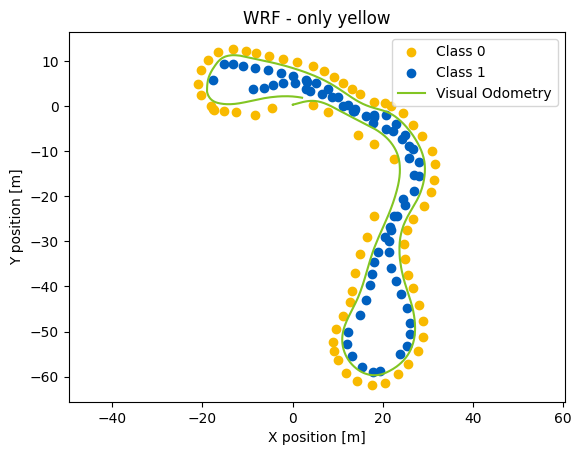

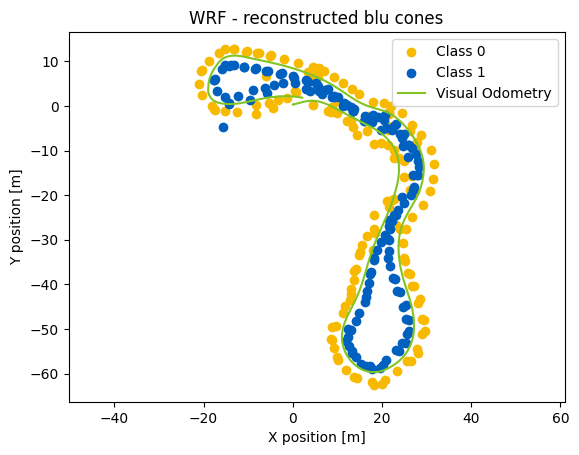

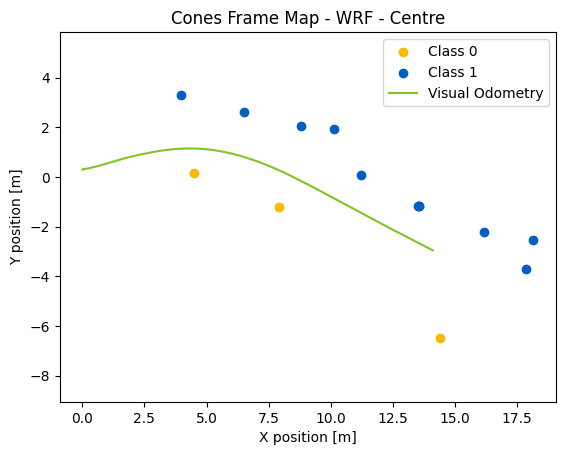

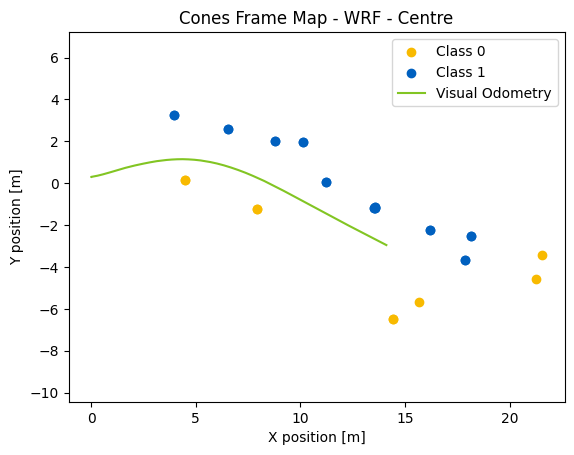

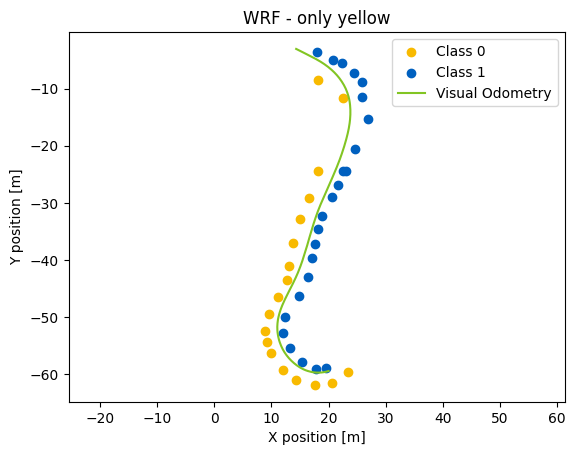

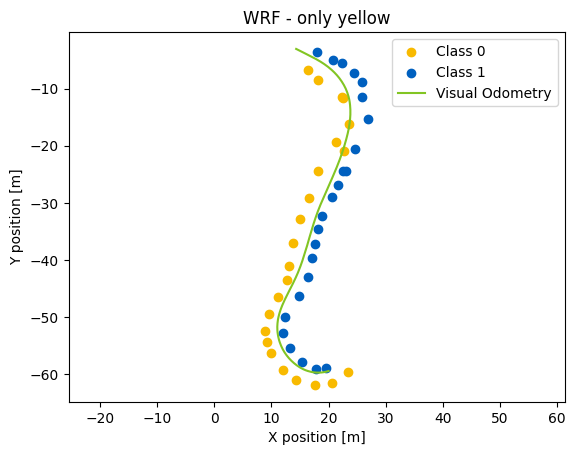

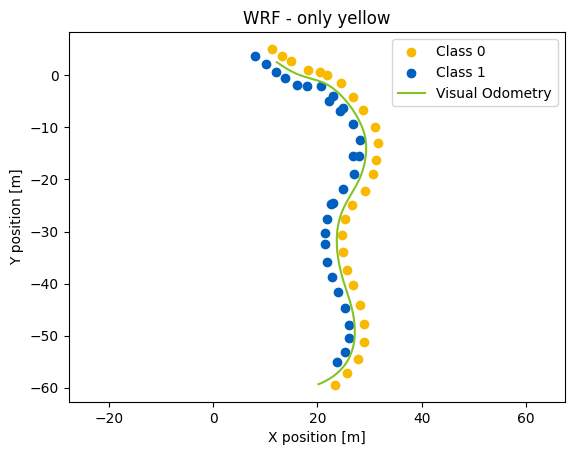

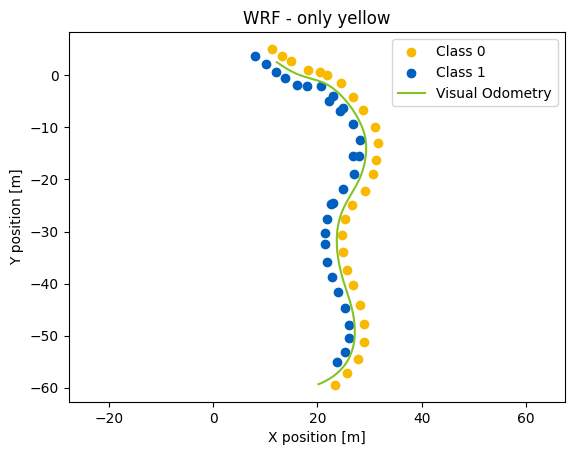

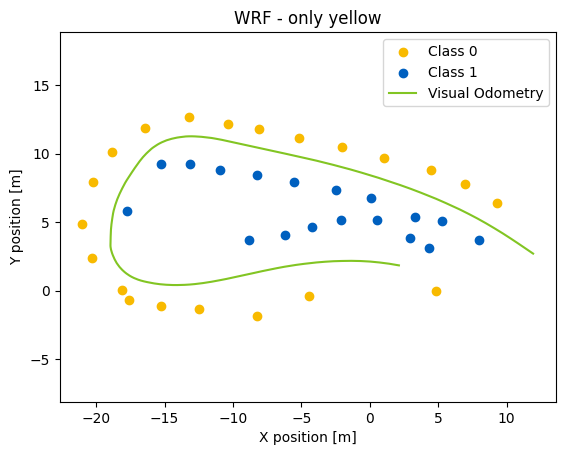

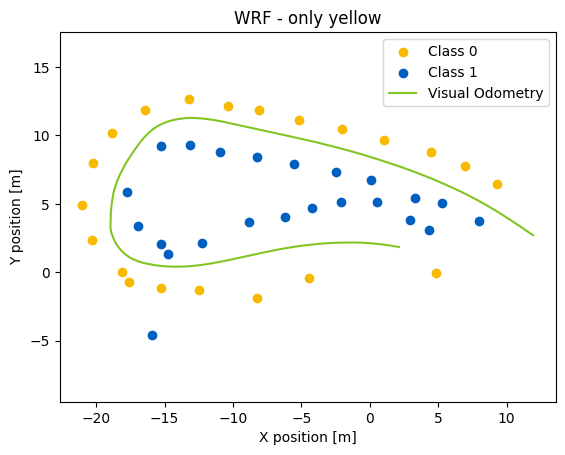

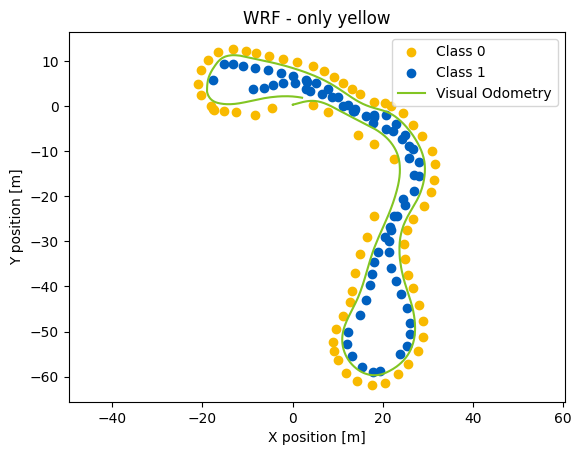

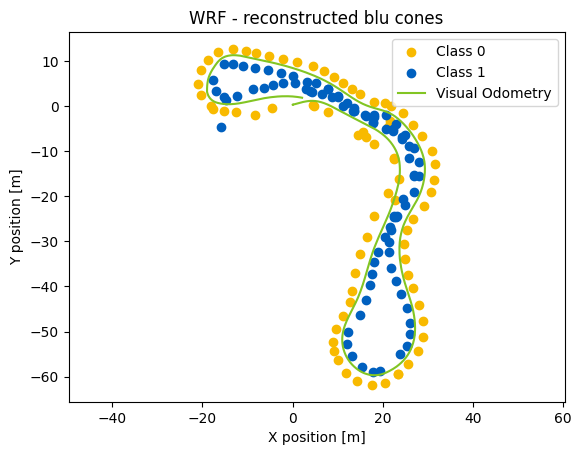

In [72]:
# Adding missing cones Function 

def process_cones(cones_coord_world, distance_threshold, dist):

    cones_coord_world = np.array(cones_coord_world)
    positions = cones_coord_world[:, 1:3]

    kdtree = cKDTree(positions)

    new_cones = []

    for cone in cones_coord_world:
        new_cones.append(cone)
        indices = kdtree.query_ball_point(cone[1:3], distance_threshold)

        if cone[0] == 0:
            class_to_find = 1
        elif cone[0] == 1:
            class_to_find = 0
        else:
            continue

        if len(indices) > 1:
            distances = np.linalg.norm(cones_coord_world[indices][:, 1:3] - cone[1:3], axis=1)

            min_distance_indices = np.argsort(distances)[:40]
            min_distance_cones = cones_coord_world[indices][min_distance_indices]

            original_indices_same = []
            original_indices_other = []

            for i in range(len(min_distance_indices)):
                real_index = indices[min_distance_indices[i]]
                if (cones_coord_world[real_index][0] == cone[0]):
                    original_indices_same.append(real_index)
                else:
                    original_indices_other.append(real_index)

            min_distance_cones_other = min_distance_cones[min_distance_cones[:, 0] == class_to_find]
            min_distance_cones_same = min_distance_cones[min_distance_cones[:, 0] == cone[0]]

            if (len(min_distance_cones_other) < 2):
                index_1 = original_indices_same[0]
                if (index_1 < original_indices_same[1]):
                    v = np.array(min_distance_cones_same[1][1:3]) - np.array(min_distance_cones_same[0][1:3])
                else:
                    v = np.array(- min_distance_cones_same[1][1:3]) + np.array(min_distance_cones_same[0][1:3])

                v = v / np.linalg.norm(v, 2)

                if class_to_find == 1:
                    w = np.dot(np.array([[0, -1], [1, 0]]), v)

                if class_to_find == 0:
                    w = np.dot(np.array([[0, 1], [-1, 0]]), v)
                
                new_cone = np.array(cone[1:3]) + 3.5 * w
                new_cone_to_add = [class_to_find, new_cone[0], new_cone[1], 0]
                new_cones.append(new_cone_to_add)
                continue
            
            if (len(min_distance_cones_same) < 2):
                continue

            _, x1, y1, _ = cone[:4]
            _, x2, y2, _= min_distance_cones_same[0][:4]
            _, x3, y3, _= min_distance_cones_same[1][:4]

            d1s = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            d2s = np.sqrt((x1-x3)**2 + (y1-y3)**2)
                
            if (len(min_distance_cones_other > 1)):

                _, x1, y1, _ = cone[:4]
                index_1 = original_indices_same[0]
                _, x2, y2, _= min_distance_cones_other[0][:4]
                _, x3, y3, _= min_distance_cones_other[1][:4]

                d1 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
                d2 = np.sqrt((x1-x3)**2 + (y1-y3)**2)

                point1 = np.array([x1, y1])
                point2 = np.array([x2, y2])
                point3 = np.array([x3, y3])

                if (d1 < 0.35 or d2 < 0.35):
                    continue    

                if (d1 > dist or d2 > dist):

                    if (len(min_distance_cones_same > 1)):
                        if ((cone[0] == min_distance_cones_same[0][0]) and (cone[1] != min_distance_cones_same[1][1]) and (cone[2] != min_distance_cones_same[1][2])):

                            if (index_1 < original_indices_same[1]):
                                v = np.array(min_distance_cones_same[1][1:3]) - np.array(min_distance_cones_same[0][1:3])
                            else:
                                v = np.array(- min_distance_cones_same[1][1:3]) + np.array(min_distance_cones_same[0][1:3])

                            v = v / np.linalg.norm(v, 2)

                            if class_to_find == 1:
                                w = np.dot(np.array([[0, -1], [1, 0]]), v)

                            if class_to_find == 0:
                                w = np.dot(np.array([[0, 1], [-1, 0]]), v)
                            
                            new_cone = np.array(cone[1:3]) + 3.5 * w
                            new_cone_to_add = [class_to_find, new_cone[0], new_cone[1], 0]
                            new_cones.append(new_cone_to_add)

    return new_cones


def filtra_coni(lista_coni, distanza):
    coni_selezionati = []

    for cono1 in lista_coni:
        _, x1, y1, _ = cono1  
        aggiungi_cono = True

        for cono2 in coni_selezionati:
            _, x2, y2, _ = cono2  
            distanza_traconi = ((x2 - x1)**2 + (y2 - y1)**2)**0.5

            if distanza_traconi < distanza:
                aggiungi_cono = False
                if abs(x1) < abs(x2):  

                    coni_selezionati.append(cono1)
                break

        if aggiungi_cono:
            coni_selezionati.append(cono1)

    return coni_selezionati
    
    
total_cones = []
for i in range (numberFrame_cone): 
    cones0 = []
    cones1 = []
    for j in range (len(objects_data_world_centre[i])):  
        cone = objects_data[i][j]
        if cone[0] == 0:
            cones0.append(cone)
        if cone[0] == 1:
            cones1.append(cone)
    
    new_cones0 = filtra_coni(cones0, 3)
    new_cones1 = filtra_coni(cones1, 2.5)

    new_cones = new_cones0 + new_cones1 

    total_cones.append(new_cones)

conesMap = cones_map(total_cones, position_center_complete, numberFrame_cone)

conesMap = merge_cones(conesMap, 0.5)
plotCones(conesMap, position_center_complete, "WRF - only yellow")


new_one = process_cones(conesMap, 6, 2)
plotCones(new_one, position_center_complete, "WRF - reconstructed blu cones")

# Devo trovare qui il modo di dividere in sezioni, vediamo se si riesce in qualche modo

poistion_1 = position_center_complete[:len(position_center_complete)//4]
position_2 = position_center_complete[len(position_center_complete)//4:2*len(position_center_complete)//4]
position_3 = position_center_complete[2*len(position_center_complete)//4:3*len(position_center_complete)//4]
position_4 = position_center_complete[3*len(position_center_complete)//4:]

obects_1 = total_cones[:len(total_cones)//4]
obects_2 = total_cones[len(total_cones)//4:2*len(total_cones)//4]
obects_3 = total_cones[2*len(total_cones)//4:3*len(total_cones)//4]
obects_4 = total_cones[3*len(total_cones)//4:]

conesMap = cones_map(obects_1, poistion_1, len(poistion_1))
conesMap = merge_cones(conesMap, 0.5)
plotCones(conesMap, poistion_1, "Cones Frame Map - WRF - Centre")
new1 = process_cones(conesMap, 8, 8)
plotCones(new1 + conesMap, poistion_1, "Cones Frame Map - WRF - Centre")

conesMap = cones_map(obects_2, position_2, len(position_2))
conesMap = merge_cones(conesMap, 0.5)
plotCones(conesMap, position_2, "WRF - only yellow")
new2 = process_cones(conesMap, 8, 8)
plotCones(new2, position_2, "WRF - only yellow")

conesMap = cones_map(obects_3, position_3, len(position_3))
conesMap = merge_cones(conesMap, 0.5)
plotCones(conesMap, position_3, "WRF - only yellow")
new3 = process_cones(conesMap, 8, 8)
if (len(new3) > 0):
    plotCones(new3, position_3, "WRF - only yellow") # qui potrebbe sempre essere che non sia stato aggiunto nessun cono

conesMap = cones_map(obects_4, position_4, len(position_4))
conesMap = merge_cones(conesMap, 0.7)
plotCones(conesMap, position_4, "WRF - only yellow")
new4 = process_cones(conesMap, 8, 8)
if (len(new4) > 0):
    plotCones(new4, position_4, "WRF - only yellow") # qui potrebbe sempre essere che non sia stato aggiunto nessun cono

conesMap = cones_map(total_cones, position_center_complete, numberFrame_cone)
conesMap = merge_cones(conesMap, 0.5)
plotCones(conesMap, position_center_complete, "WRF - only yellow")
new_one = new1 + new2 + new3 + new4
plotCones(new_one, position_center_complete, "WRF - reconstructed blu cones")


## Boundaries

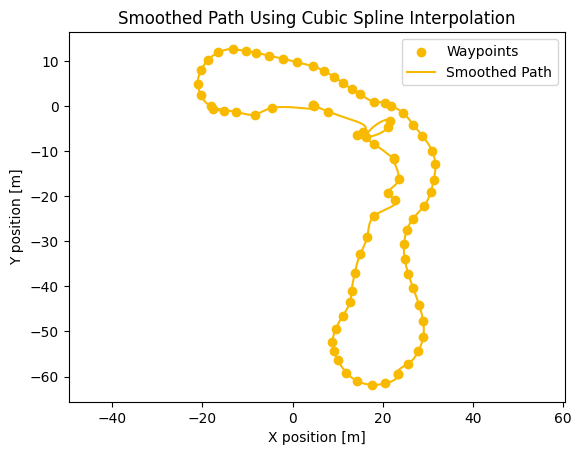

In [80]:
trajectory_points = []
for i in range (len(new_one)):
    cone = new_one[i]
    if cone[0] == 1:
        continue
    x_cone, y_cone = cone[1], cone[2]
    trajectory_points.append((x_cone, y_cone))

trajectory_points = np.array(trajectory_points)

# Append an endpoint to create a closed shape (optional)
x, y = trajectory_points.T
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# Create a spline function
f, u = interpolate.splprep([x, y], s=0, per=True)

# Generate interpolated points
num_points = 1000  # Adjust as needed
xint, yint = interpolate.splev(np.linspace(0, 1, num_points), f)

# Plot original waypoints and smoothed path
plt.scatter(x, y, label="Waypoints", color = (248/255, 186/255, 0))
plt.plot(xint, yint, label="Smoothed Path", color=(248/255, 186/255, 0))
plt.xlabel("X position [m]")
plt.ylabel("Y position [m]")
plt.axis("equal")
plt.title("Smoothed Path Using Cubic Spline Interpolation")
plt.legend()
plt.show()

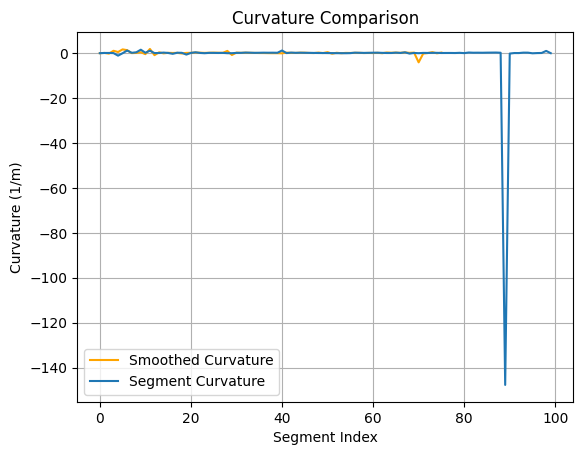

In [81]:
# Append an endpoint to create a closed shape (optional)
x, y = trajectory_points.T
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# Create a spline function
f, u = interpolate.splprep([x, y], s=0, per=True)

# Generate interpolated points
num_points = 100
xint, yint = interpolate.splev(np.linspace(0, 1, num_points), f)

# Calculate segment curvatures
segment_curvatures = []
for i in range(len(x) - 1):
    # Compute derivatives at each segment
    dx_dt, dy_dt = interpolate.splev(u[i], f, der=1)
    d2x_dt2, d2y_dt2 = interpolate.splev(u[i], f, der=2)
    
    # Calculate curvature
    curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    segment_curvatures.append(curvature)

# Calculate smoothed path curvature
smoothed_curvatures = []
for t in np.linspace(0, 1, num_points):
    dx_dt, dy_dt = interpolate.splev(t, f, der=1)
    d2x_dt2, d2y_dt2 = interpolate.splev(t, f, der=2)
    curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    smoothed_curvatures.append(curvature)

# Plot segment and smoothed curvatures
plt.figure()
plt.plot(segment_curvatures, label="Smoothed Curvature", color="orange")
plt.plot(smoothed_curvatures, label="Segment Curvature")
plt.xlabel("Segment Index")
plt.ylabel("Curvature (1/m)")
plt.title("Curvature Comparison")
plt.legend()
plt.grid(True)
plt.show()

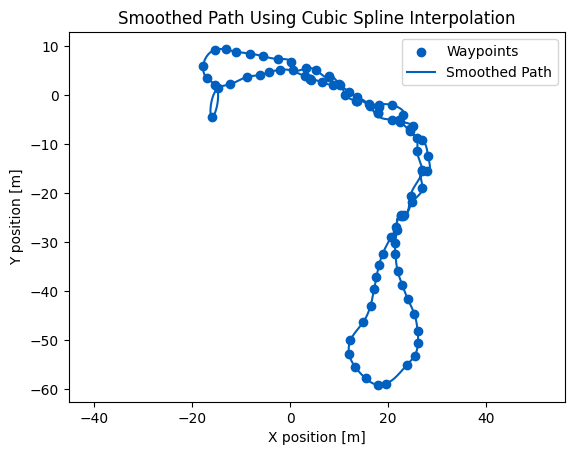

In [83]:
# The same but for the other boundary

trajectory_points = []
for i in range (len(new_one)):
    cone = new_one[i]
    if cone[0] == 0:
        continue
    x_cone, y_cone = cone[1], cone[2]
    trajectory_points.append((x_cone, y_cone))

trajectory_points = np.array(trajectory_points)

# Append an endpoint to create a closed shape (optional)
x, y = trajectory_points.T
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# Create a spline function
f, u = interpolate.splprep([x, y], s=0, per=True)

# Generate interpolated points
num_points = 1000  # Adjust as needed
xint, yint = interpolate.splev(np.linspace(0, 1, num_points), f)

# Plot original waypoints and smoothed path
plt.scatter(x, y, label="Waypoints", color = (0/255, 96/255, 191/255))
plt.plot(xint, yint, label="Smoothed Path", color= (0/255, 96/255, 191/255))
plt.xlabel("X position [m]")
plt.ylabel("Y position [m]")
plt.axis("equal")
plt.title("Smoothed Path Using Cubic Spline Interpolation")
plt.legend()
plt.show()

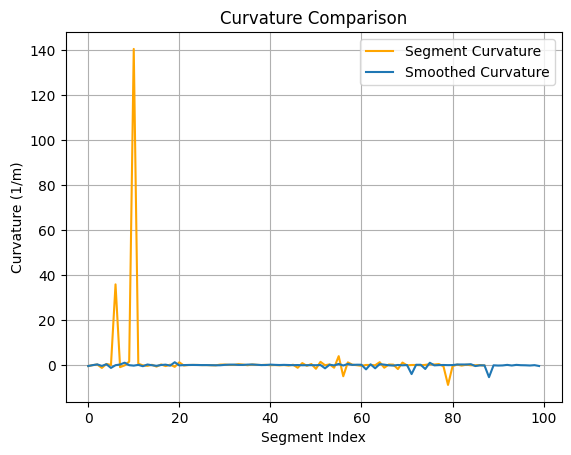

In [85]:
# The same but for the other boundary
# Append an endpoint to create a closed shape (optional)
x, y = trajectory_points.T
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# Create a spline function
f, u = interpolate.splprep([x, y], s=0, per=True)

# Generate interpolated points
num_points = 100
xint, yint = interpolate.splev(np.linspace(0, 1, num_points), f)

# Calculate segment curvatures
segment_curvatures = []
for i in range(len(x) - 1):
    # Compute derivatives at each segment
    dx_dt, dy_dt = interpolate.splev(u[i], f, der=1)
    d2x_dt2, d2y_dt2 = interpolate.splev(u[i], f, der=2)
    
    # Calculate curvature
    curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    segment_curvatures.append(curvature)

# Calculate smoothed path curvature
smoothed_curvatures = []
for t in np.linspace(0, 1, num_points):
    dx_dt, dy_dt = interpolate.splev(t, f, der=1)
    d2x_dt2, d2y_dt2 = interpolate.splev(t, f, der=2)
    curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    smoothed_curvatures.append(curvature)

# Plot segment and smoothed curvatures
plt.figure()
plt.plot(segment_curvatures, label="Smoothed Curvature", color="orange")
plt.plot(smoothed_curvatures, label="Segment Curvature")
plt.xlabel("Segment Index")
plt.ylabel("Curvature (1/m)")
plt.title("Curvature Comparison")
plt.legend()
plt.grid(True)
plt.show()